In [ ]:
import sys
sys.path
sys.path.append('/volatile/aurelien_stumpf_mascles/project/code/')

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import cebra_v2 as cebra2
from collections import defaultdict

In [2]:
import importlib
importlib.reload(cebra2.dataset)
importlib.reload(cebra2.solver)
importlib.reload(cebra2.criterion)

<module 'cebra_v2.criterion' from '/volatile/aurelien_stumpf_mascles/project/code/cebra_v2/criterion.py'>

In [3]:
loaded_arrays = np.load('/neurospin/lbi/monkeyfmri/deepstim/database/SYNTHETIC_database/sub-200_states-4_noise-high_synth/dataset.npz')
print(loaded_arrays.files)

['data25', 'dfc25', 'labels25', 'data30', 'dfc30', 'labels30', 'data35', 'dfc35', 'labels35', 'data40', 'dfc40', 'labels40', 'data45', 'dfc45', 'labels45', 'states']


In [4]:
data25 = loaded_arrays['data25']
labels25 = loaded_arrays["labels25"][:,:,-1]

In [5]:
def generate_corr_matrix(data):
    n,m,p,_ = data25.shape
    corr_matrix = np.zeros((n,m,p,p))
    for i in range(n):
        for j in range(m):
            corr_matrix[i,j,:,:] = np.corrcoef(data25[i,j,:,:])
    corr_matrix = torch.unsqueeze(torch.from_numpy(corr_matrix),dim=2)
    return corr_matrix

In [6]:
def generate_matrix_distance(data):
    nb_session,time,_,_ = data.shape
    distance_matrix = np.zeros((nb_session,time,nb_session,time)) 
    for session1 in range(nb_session):
        print(session1)
        for t1 in range(time):
            for session2 in range(nb_session):
                for t2 in range(time):
                    if session1 == session2 : 
                        distance_matrix[session1,t1,session2,t2] = 0
                    else :
                        distance_matrix[session1,t1,session2,t2] = np.linalg.norm(data[session1,t1,:,:] - data[session2,t2,:,:])
    return distance_matrix
    

In [139]:
aux = corr_matrix[0:10,:,:,:]
distance_matrix = generate_matrix_distance(aux)

0
1
2
3
4
5
6
7
8
9


In [140]:
list_distance = distance_matrix.flatten()
list_distance = np.sort(list_distance)

(array([2.0000e+00, 0.0000e+00, 2.0000e+00, 2.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 2.0000e+00, 4.0000e+00, 2.0000e+00,
        2.0000e+00, 2.0000e+00, 2.0000e+00, 6.0000e+00, 2.0000e+00,
        6.0000e+00, 2.0000e+00, 2.0000e+00, 6.0000e+00, 6.0000e+00,
        1.4000e+01, 4.0000e+00, 8.0000e+00, 4.0000e+00, 1.0000e+01,
        1.2000e+01, 1.6000e+01, 2.2000e+01, 6.0000e+00, 1.2000e+01,
        1.6000e+01, 1.4000e+01, 2.2000e+01, 1.6000e+01, 1.0000e+01,
        1.6000e+01, 3.2000e+01, 4.4000e+01, 2.4000e+01, 2.8000e+01,
        4.0000e+01, 5.0000e+01, 3.8000e+01, 2.4000e+01, 4.6000e+01,
        5.6000e+01, 4.4000e+01, 5.4000e+01, 5.2000e+01, 6.6000e+01,
        5.6000e+01, 7.2000e+01, 5.2000e+01, 6.2000e+01, 6.0000e+01,
        6.2000e+01, 7.0000e+01, 7.8000e+01, 9.2000e+01, 7.4000e+01,
        1.2600e+02, 6.0000e+01, 1.2400e+02, 1.2000e+02, 1.1600e+02,
        1.2800e+02, 1.5400e+02, 1.5000e+02, 1.8800e+02, 1.6400e+02,
        1.5400e+02, 1.7200e+02, 1.7600e+02, 1.82

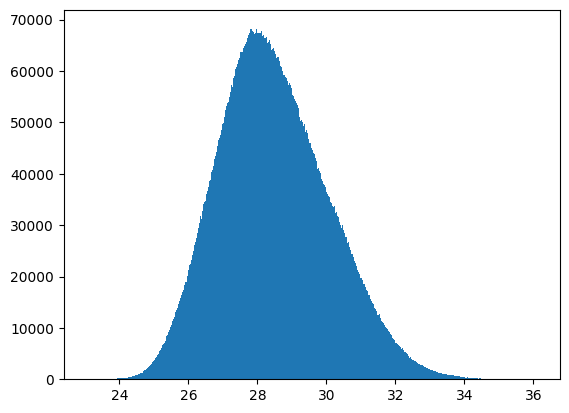

In [141]:
plt.hist(list_distance[list_distance > 0],bins=1000)

In [152]:
np.linalg.norm(np.random.uniform(0,1,size = (82,82)) - np.random.uniform(0,1,size = (82,82)))

33.94726303500909

In [136]:
def condition(x,session):
    return x[0] != session

def argmin_distance(data,session,t):
    corr = data[session,t]
    distance = np.sqrt(np.sum((data - corr)**2,axis=(2,3)))
    li_indices = np.argwhere(distance < 25.3)
    li_indices = np.where(np.apply_along_axis(lambda x : x[0] == session, axis = 0, arr = li_indices),li_indices,li_indices)
    return len(li_indices[np.apply_along_axis(lambda x : x[0] != session, axis = 1, arr = li_indices)])

def generate_close_indices(data):
    dict_adjacency = defaultdict(lambda  : defaultdict(list))
    nb_session,time,_,_ = data.shape
    res = 0
    for session in range(nb_session):
        print(session)
        for t in range(time):
            x = argmin_distance(data,session,t)
            #dict_adjacency[session][t] = x
            print(x)
    return res
    #return dict_adjacency

In [137]:
d = generate_close_indices(corr_matrix)

0
0
0
0
0
0
0
0
0
0
0
0
0


KeyboardInterrupt: 

In [253]:
def single_session_solver(data_loader, **kwargs):
    """Train a single session CEBRA model."""
    norm = True
    if kwargs['distance'] == 'euclidean':
        norm = False
    model = kwargs["model"]

    if kwargs['distance'] == 'euclidean':
        criterion = cebra2.criterion.EuclideanInfoNCE(temperature=kwargs['temperature'])
    elif kwargs['distance'] == 'cosine':        
        criterion = cebra2.criterion.CosineInfoNCE(temperature=kwargs['temperature'])

    optimizer = torch.optim.Adam(model.parameters(), lr=kwargs['learning_rate'])

    return cebra2.solver.SingleSessionSolver(model=model,
                                            criterion=criterion,
                                            optimizer=optimizer)

In [254]:
@torch.no_grad()
def get_emissions(model, dataset):
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
    model.to(device)
    return model(dataset).cpu().numpy()

def _compute_emissions_single(solver, dataset):
    return get_emissions(solver.model, dataset)

In [255]:
num_output = 3
normalize = True
num_neurons = 4000

model = cebra2.model.Model(
    nn.Conv2d(in_channels = 1, out_channels = 10, kernel_size = 4, padding = 1 ),
    nn.MaxPool2d(kernel_size = 4),
    nn.Flatten(start_dim=1, end_dim=-1),
    nn.Linear(
        num_neurons,
        num_output * 30,
    ),
    nn.GELU(),
    nn.Linear(num_output * 30, num_output * 30),
    nn.GELU(),
    nn.Linear(num_output * 30, num_output * 10),
    nn.GELU(),
    nn.Linear(int(num_output * 10), num_output),
    num_input=num_neurons,
    num_output=num_output
        )

In [256]:
fc_dataset = cebra2.dataset.TensorDataset(corr_matrix[0,:,:],discrete = labels25[0,:])
fc_loader = cebra2.dataset.Loader(fc_dataset, num_steps = 1000, batch_size = 128, time_delta = 15)

In [257]:
cebra_fc = single_session_solver(data_loader = fc_loader, model_architecture = 'offset1-model', 
                 distance = 'euclidean', num_hidden_units = 128, output_dimension = 128,
                verbose = True, temperature = 1, learning_rate = 3e-4, model = model)

In [258]:
cebra_fc.fit(fc_loader)

Epoch 0
Train loss 4.8519, Train accuracy 0.00%
Epoch 100
Train loss 3.8260, Train accuracy 0.00%
Epoch 200
Train loss 3.7925, Train accuracy 0.00%
Epoch 300
Train loss 3.8259, Train accuracy 0.00%
Epoch 400
Train loss 3.7871, Train accuracy 0.00%
Epoch 500
Train loss 3.8022, Train accuracy 0.00%
Epoch 600
Train loss 3.7939, Train accuracy 0.00%
Epoch 700
Train loss 3.7585, Train accuracy 0.00%
Epoch 800
Train loss 3.7644, Train accuracy 0.00%
Epoch 900
Train loss 3.6904, Train accuracy 0.00%


In [237]:
labels25[0,:]

array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

(-1.0854163825511933,
 0.8693143784999847,
 -1.0489016771316528,
 1.017108678817749)

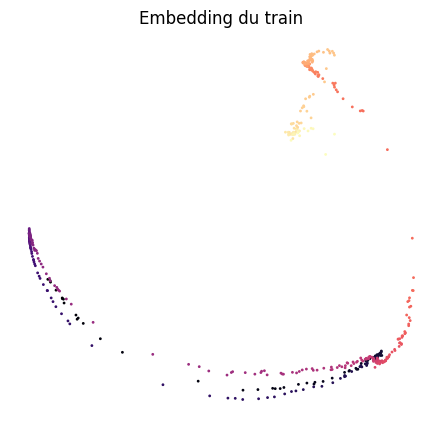

In [234]:
fc_emb = _compute_emissions_single(cebra_fc, fc_dataset.neural)
fig = plt.figure(figsize = (12,5))

ax1 = plt.subplot(121)
ax1.set_title('Embedding du train')
ax1.scatter(fc_emb[:,0], fc_emb[:,1], cmap = 'magma', c = np.arange(475), s=1)
ax1.axis('off')

In [239]:
labels25[1,:]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2.

(-1.037047153711319,
 0.9489594757556915,
 -1.0483627749606967,
 0.05919809099286795)

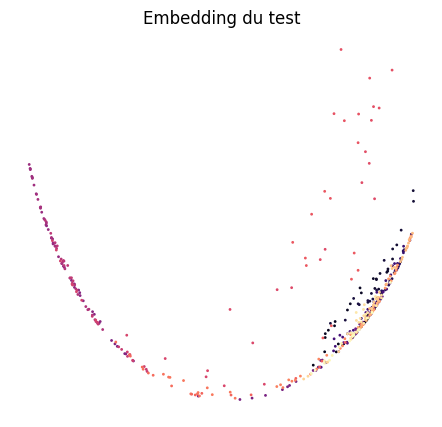

In [236]:
test = corr_matrix[1,:,:]
fc_test = cebra2.dataset.TensorDataset(test)
fc_emb_test = _compute_emissions_single(cebra_fc, fc_test.neural)
fig = plt.figure(figsize = (12,5))

ax1 = plt.subplot(121)
ax1.set_title('Embedding du test')
ax1.scatter(fc_emb_test[:,0], fc_emb_test[:,1], cmap = 'magma', c = np.arange(475), s=1)
ax1.axis('off')

(-1.0248926758766175,
 1.0574142813682557,
 -1.0744733154773711,
 1.0548754274845122)

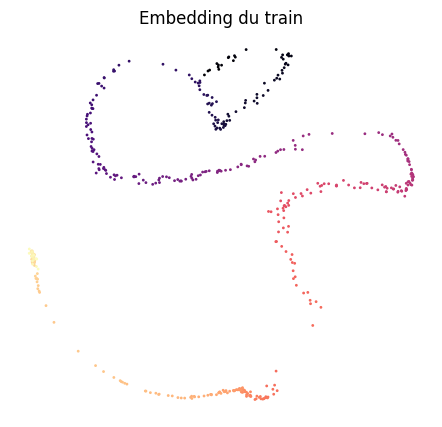

In [259]:
fc_emb = _compute_emissions_single(cebra_fc, fc_dataset.neural)
fig = plt.figure(figsize = (12,5))

ax1 = plt.subplot(121)
ax1.set_title('Embedding du train')
ax1.scatter(fc_emb[:,0], fc_emb[:,1], cmap = 'magma', c = np.arange(475), s=1)
ax1.axis('off')

(-0.8455379456281662,
 1.0784147828817368,
 -0.9756637781858444,
 1.089425978064537)

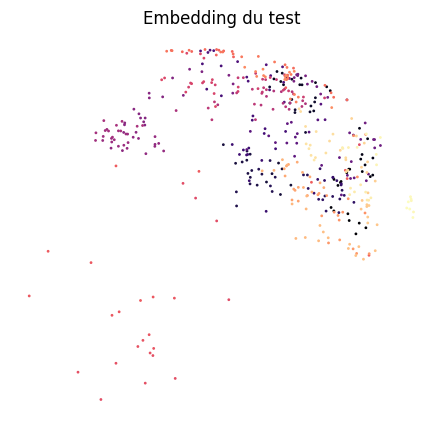

In [260]:
test = corr_matrix[1,:,:]
fc_test = cebra2.dataset.TensorDataset(test)
fc_emb_test = _compute_emissions_single(cebra_fc, fc_test.neural)
fig = plt.figure(figsize = (12,5))

ax1 = plt.subplot(121)
ax1.set_title('Embedding du test')
ax1.scatter(fc_emb_test[:,0], fc_emb_test[:,1], cmap = 'magma', c = np.arange(475), s=1)
ax1.axis('off')